<a href="https://colab.research.google.com/github/xqhuang123/xqhuang/blob/master/GNN_smiles2graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install RDKit. Takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2020-09-18 21:02:06--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-09-18 21:02:06--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | / - 

In [5]:
!pip install dgl

In [6]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

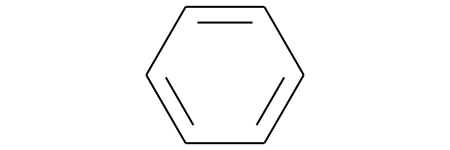

In [7]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

Chem.MolFromSmiles('c1ccccc1')

In [8]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import RDConfig
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import dgl
import dgl.function as fn
from dgl import DGLGraph

Using backend: pytorch


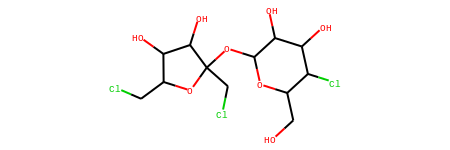

In [9]:
smiles="ClCC1OC(C(C1O)O)(CCl)OC1OC(CO)C(C(C1O)O)Cl"
mol=Chem.MolFromSmiles(smiles)
mol

In [10]:
ELEM_LIST = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'Al', 'I', 'B', 'K', 'Se',
 'Zn', 'H', 'Cu', 'Mn', 'unknown']
ATOM_FDIM = len(ELEM_LIST) + 6 + 5 + 4 + 1 # 23 + degree, charge, is_aromatic = 39

In [18]:
mol.GetNumAtoms()

23

In [21]:
def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: 
        return None
    Chem.Kekulize(mol)
    return mol
def onek_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]
def atom_features(atom):
    return (torch.Tensor(onek_encoding_unk(atom.GetSymbol(), ELEM_LIST) 
            + onek_encoding_unk(atom.GetDegree(), [0,1,2,3,4,5]) 
            + onek_encoding_unk(atom.GetFormalCharge(), [-1,-2,1,2,0])
            + onek_encoding_unk(int(atom.GetChiralTag()), [0,1,2,3])
            + [atom.GetIsAromatic()]))
def mol2dgl_single(mols):
    """
    inputs
      mols: a list of molecules
    outputs
      cand_graphs: a list of dgl graphs
    """
    cand_graphs = []
    for mol in mols:
        n_atoms = mol.GetNumAtoms()
        g = DGLGraph()        
        node_feats = []
        for i, atom in enumerate(mol.GetAtoms()):
            assert i == atom.GetIdx()
            node_feats.append(atom_features(atom))
        g.add_nodes(n_atoms)
        bond_src = []
        bond_dst = []
        for i, bond in enumerate(mol.GetBonds()):
            a1 = bond.GetBeginAtom()
            a2 = bond.GetEndAtom()
            begin_idx = a1.GetIdx()
            end_idx = a2.GetIdx()
            bond_src.append(begin_idx)
            bond_dst.append(end_idx)
            bond_src.append(end_idx)
            bond_dst.append(begin_idx)
        g.add_edges(bond_src, bond_dst)
        g.ndata['h'] = torch.Tensor([a.tolist() for a in node_feats])
        cand_graphs.append(g)
    return cand_graphs

In [22]:
smiles = ['OCCS(=O)(=O)c1no[n+]([O-])c1c2ccccc2', 'Cl.CCCC1(C)CC(=O)N(CCCCN2CCN(CC2)c3nsc4ccccc34)C(=O)C1']
mols = []
for sm in smiles:
    mol = get_mol(sm)
    mols.append(mol)
graphs = mol2dgl_single(mols)

/usr/local/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [25]:
print(graphs[0])
print(graphs[1])

Graph(num_nodes=18, num_edges=38,
      ndata_schemes={'h': Scheme(shape=(39,), dtype=torch.float32)}
      edata_schemes={})
Graph(num_nodes=32, num_edges=68,
      ndata_schemes={'h': Scheme(shape=(39,), dtype=torch.float32)}
      edata_schemes={})


In [26]:
graphs[0].adjacency_matrix().to_dense()

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0.,

In [27]:
graphs[1].adjacency_matrix().to_dense()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])